In [19]:
from src.data_structures import *
from src.shortest_path import RoutePlaner
from src.utlis import *
import pickle
import importlib
import pandas as pd
import os

with open("mpk_graph.pickle", "rb") as f:
    graph = pickle.load(f)


In [27]:
import random

def generate_random_test_cases(bus_stops_names, num_tests=10):
    test_cases = []
    
    for _ in range(num_tests):
        start_stop, end_stop = random.sample(bus_stops_names, 2) 
        departure_time = f"{random.randint(6, 21):02d}:{random.randint(0, 59):02d}:00"

        test_cases.append({
            "start_stop": start_stop,
            "end_stop": end_stop,
            "departure_time": departure_time
        })
    
    return test_cases


bus_stops_names = list(graph.keys())
test_cases = generate_random_test_cases(bus_stops_names, num_tests=50)

In [21]:
bus_stop_names = graph.keys()
wroclaw_route_planer = RoutePlaner(graph) 


start_stop = "Wilczyce - Sosnowa"
end_stop= "Kołobrzeska"
departure_time = "07:00:00"

totaltime, route, visited_nodes, visited_connections = wroclaw_route_planer.astar_changes(
    start_stop=start_stop,
    end_stop=end_stop,
    departure_time=departure_time,
    
)


def calculate_number_of_transfers(route):
    number_of_transfers = 0

    for i in range(len(route) - 1):
        if route[i].line != route[i + 1].line:
            number_of_transfers += 1

    return number_of_transfers

calculate_number_of_transfers(route)

4

In [28]:


results = []
heuristics = [
    (wroclaw_route_planer.euclidean_distance_heuristic, "Euclidean Distance"),
    (wroclaw_route_planer.angle_between_heuristic, "Angle Between"),
    (wroclaw_route_planer.zero_heuristic, "Zero Heuristic"),
    (wroclaw_route_planer.haversine_distance_heuristic, "Haversine Distance")
]


totaltime, route, visited_nodes, visited_connections = wroclaw_route_planer.astar_changes(
    start_stop=start_stop,
    end_stop=end_stop,
    departure_time=departure_time,
    
)

def run_astar_changes(start_stop, end_stop, departure_time):
    try:
        totaltime, route, visited_nodes, visited_connections = wroclaw_route_planer.astar_changes(
            start_stop=start_stop,
            end_stop=end_stop,
            departure_time=departure_time,
        )
        results.append({
            "Start": start_stop,
            "End": end_stop,
            "Departure Time": departure_time,
            "Heuristic": "Haversine Changes",
            "Total Time": totaltime,
            "Visited Connections": visited_connections,
            "Visited nodes": visited_nodes,
            "Number of Transfers": calculate_number_of_transfers(route),
            "Route finding mode": "earliest"
        })
        return True
    except Exception as e:
        return False


def run_astar(start_stop, end_stop, departure_time, heuristic, heuristic_name, connection_finder_type=None):
    try:
        totaltime, route, visited_nodes, visited_connections = wroclaw_route_planer.astar(
            start_stop=start_stop,
            end_stop=end_stop,
            departure_time=departure_time,
            heuristic_function=heuristic,
            connection_finder_type=connection_finder_type
        )
        results.append({
            "Start": start_stop,
            "End": end_stop,
            "Departure Time": departure_time,
            "Heuristic": heuristic_name,
            "Total Time": totaltime,
            "Visited Connections": visited_connections,
            "Visited nodes": visited_nodes,
            "Number of Transfers": calculate_number_of_transfers(route),
            "Route finding mode": connection_finder_type if connection_finder_type else "earliest"
        })
        return True
    except Exception as e:
        return False
    



results_per_test_case = []

for test_case in test_cases:
    start_stop, end_stop, departure_time = test_case["start_stop"], test_case["end_stop"], test_case["departure_time"]
    test_case_results = []
    
    success = run_astar_changes(start_stop, end_stop, departure_time)
    for heuristic, heuristic_name in heuristics:
        success = run_astar(start_stop, end_stop, departure_time, heuristic, heuristic_name)
        
        if not success:
            break
        
        if heuristic_name == "Euclidean Distance":
            success_no_change = run_astar(start_stop, end_stop, departure_time, heuristic, heuristic_name, connection_finder_type='no_change')
            if not success_no_change:
                break

    

results_df = pd.DataFrame(results)
output_dir = "results"
output_file = "results.csv"
output_path = os.path.join(output_dir, output_file)

os.makedirs(output_dir, exist_ok=True)

if os.path.exists(output_path):
    base, ext = os.path.splitext(output_file)
    counter = 1
    while os.path.exists(output_path):
        output_file = f"{base}_{counter}{ext}"
        output_path = os.path.join(output_dir, output_file)
        counter += 1

results_df.to_csv(output_path, index=False)

In [29]:
df1 = pd.read_csv("results/results.csv")
df2 = pd.read_csv("results/results_1.csv")
df3 = pd.read_csv("results/results_2.csv")
df4 = pd.read_csv("results/results_3.csv")
df5 = pd.read_csv("results/results_4.csv")
df6 = pd.read_csv("results/results_5.csv")


df = pd.concat([df1, df2, df3, df4, df5, df6])
df.to_csv("results/results_final.csv", index=False)

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
df = df.drop_duplicates

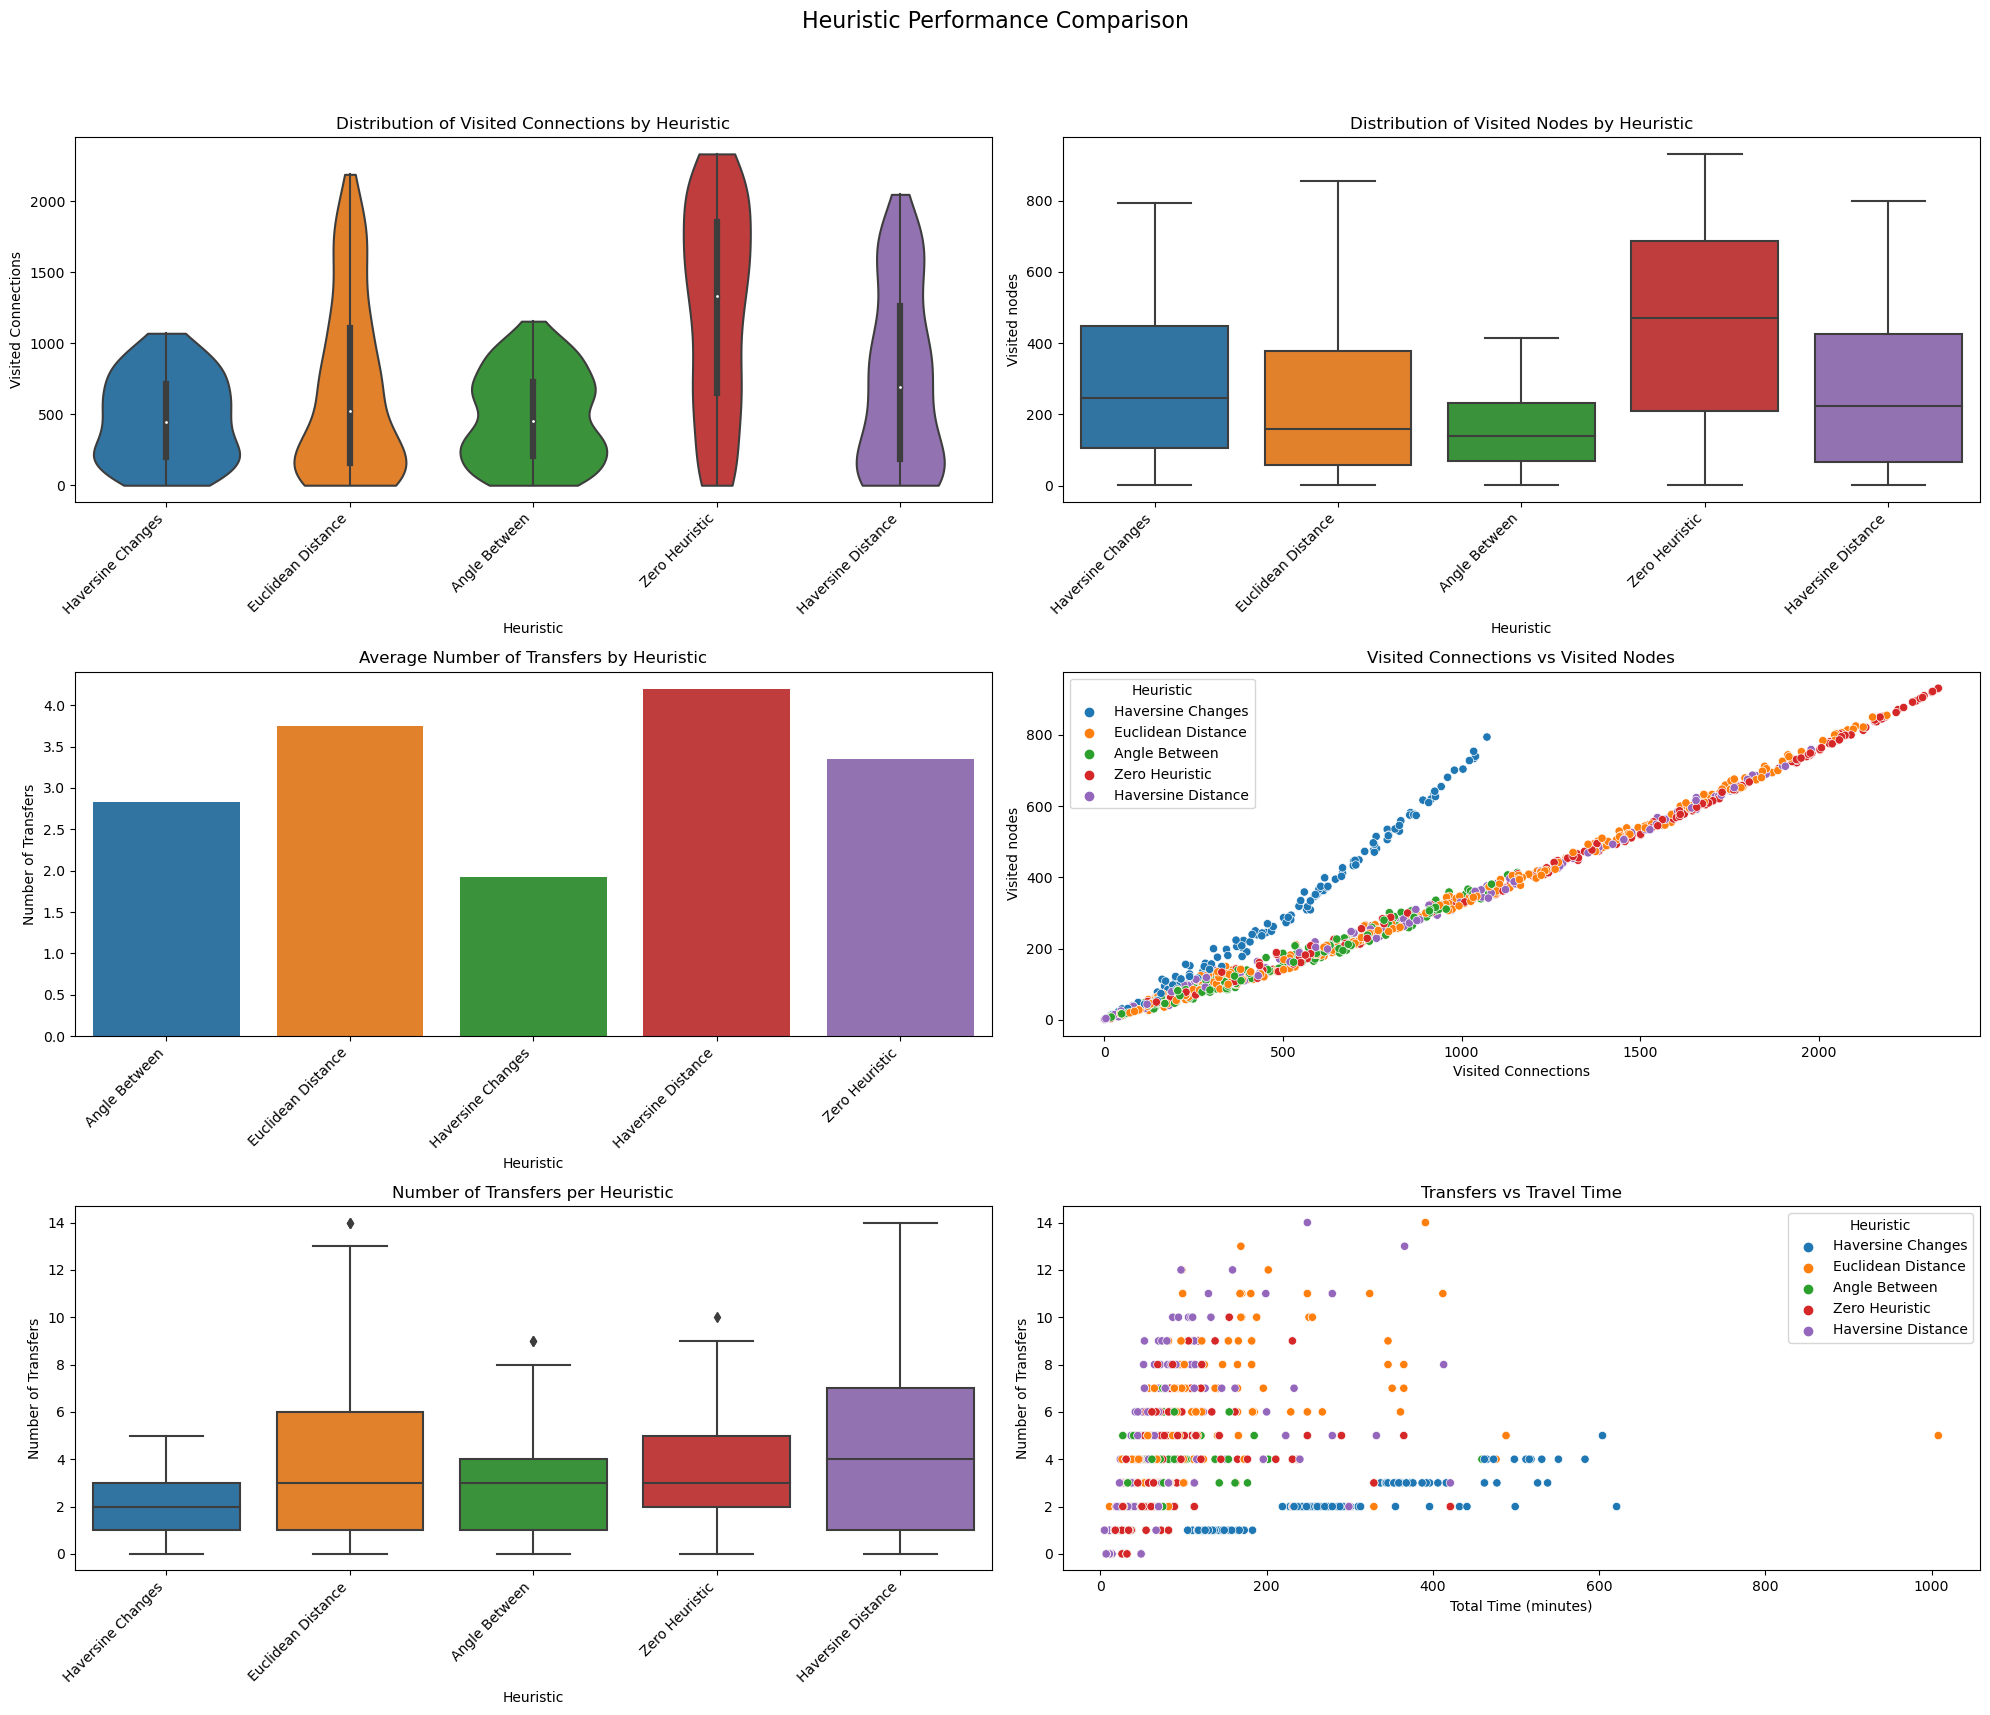

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data = pd.read_csv('results/results_final.csv')


plt.figure(figsize=(20,18))

plt.subplot(3, 2, 1)
sns.violinplot(x='Heuristic', y='Visited Connections', data=data, cut=0)
plt.title('Distribution of Visited Connections by Heuristic')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.subplot(3, 2, 2)
sns.boxplot(x='Heuristic', y='Visited nodes', data=data)
plt.title('Distribution of Visited Nodes by Heuristic')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.subplot(3, 2, 3)
sns.barplot(x='Heuristic', y='Number of Transfers', data=heuristic_summary)
plt.title('Average Number of Transfers by Heuristic')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.subplot(3, 2, 4)
sns.scatterplot(x='Visited Connections', y='Visited nodes', hue='Heuristic', data=data)
plt.title('Visited Connections vs Visited Nodes')
plt.tight_layout()

plt.subplot(3, 2, 5)
sns.boxplot(x='Heuristic', y='Number of Transfers', data=data)
plt.title('Number of Transfers per Heuristic')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.subplot(3, 2, 6)
sns.scatterplot(x='Total Time', y='Number of Transfers', hue='Heuristic', data=data)
plt.title('Transfers vs Travel Time')
plt.xlabel('Total Time (minutes)')
plt.ylabel('Number of Transfers')
plt.legend(title='Heuristic')
plt.tight_layout()

plt.suptitle('Heuristic Performance Comparison', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

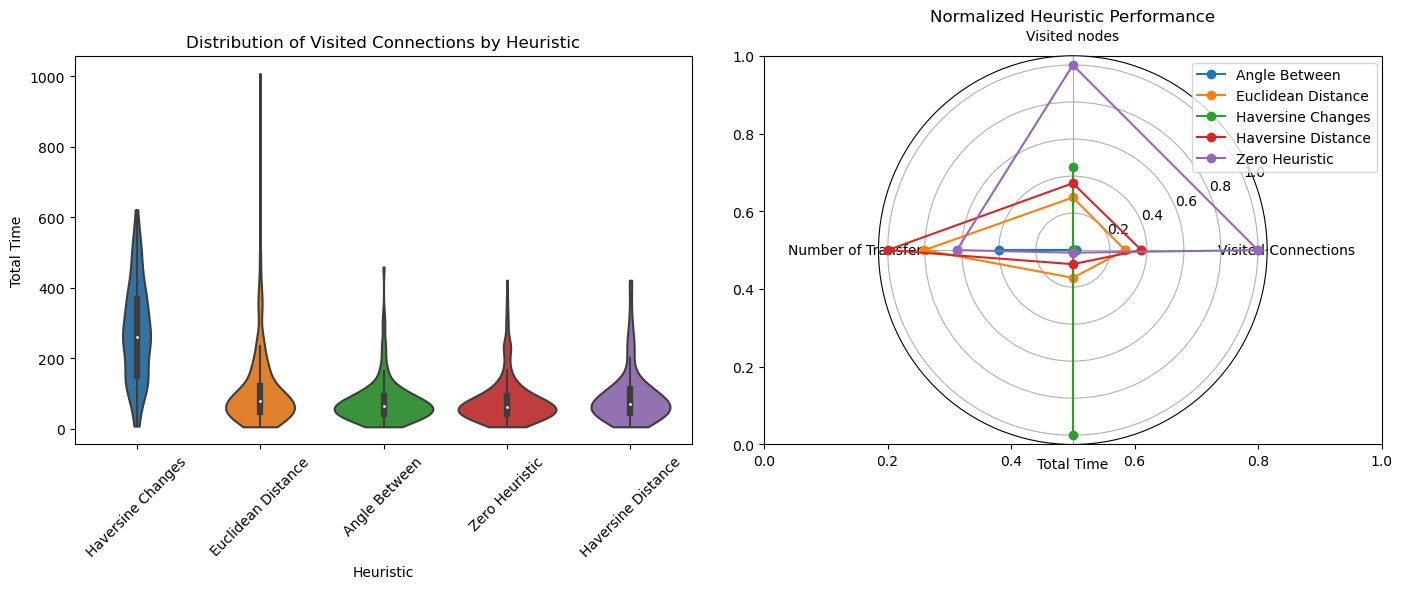

            Heuristic  Visited Connections  ...  Number of Transfers  Total Time
0       Angle Between           481.037383  ...             2.831776   75.744444
1  Euclidean Distance           687.515439  ...             3.745843  105.517857
2   Haversine Changes           468.198630  ...             1.917808  274.576642
3  Haversine Distance           755.247191  ...             4.196629   90.848921
4      Zero Heuristic          1243.934579  ...             3.345794   78.515306

[5 rows x 5 columns]


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'polar': False})

sns.violinplot(ax=axes[0], x='Heuristic', y='Total Time', data=data, cut=0)
axes[0].set_title('Distribution of Visited Connections by Heuristic')
axes[0].tick_params(axis='x', rotation=45)

heuristic_summary = data.groupby('Heuristic').agg({
    'Visited Connections': 'mean',
    'Visited nodes': 'mean',
    'Number of Transfers': 'mean',
    'Total Time': 'mean'
}).reset_index()

normalized_summary = heuristic_summary.copy()
for col in ['Visited Connections', 'Visited nodes', 'Number of Transfers', 'Total Time']:
    normalized_summary[col] = (normalized_summary[col] - normalized_summary[col].min()) / (normalized_summary[col].max() - normalized_summary[col].min())

categories = ['Visited Connections', 'Visited nodes', 'Number of Transfers', 'Total Time']
heuristics = normalized_summary['Heuristic']

ax = fig.add_subplot(122, polar=True)
angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

for i, heuristic in enumerate(heuristics):
    values = normalized_summary.loc[i, categories].tolist()
    values += values[:1]
    ax.plot(angles, values, marker='o', label=heuristic, linestyle='-')

ax.set_thetagrids(angles[:-1] * 180/np.pi, categories)
ax.set_title('Normalized Heuristic Performance')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()

print(heuristic_summary)